# COGS 108 - EDA Checkpoint

# Names

- Aditya Sriram
- Weston Chester
- Katherine Gao
- Nicole Liu
- Sophia Conti

<a id='research_question'></a>
# Research Question

Is California on track to reach its goal of 100% zero emission sales by 2035?

Hypothesis: Based on previous data, we believe that California is on track to meet its 100% zero emission sales goal by 2035.

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data Cleaning

Describe your data cleaning steps here.

First, we imported our datasets and repeated any data cleaning that we did previously.

Starting with looking at just the ZEV Sales dataset and copying over the cleaning done from last time.

In [2]:
# Import ZEV Sales as Dataset
zev_sales = pd.read_csv('Data/zev_sales.csv')
zev_sales = zev_sales[(zev_sales['Data Year'] <= 2021) & (zev_sales['Data Year'] >= 2009)]

# ZEV sales as a percentage of cars registered by county in 2008-2021
reg_2008 = pd.read_csv('Data/Vehicles Registered By County-2008.csv', encoding='utf-16')
reg_2009 = pd.read_csv('Data/Vehicles Registered By County-2009.csv', encoding='utf-16')
reg_2010 = pd.read_csv('Data/Vehicles Registered By County-2010.csv', encoding='utf-16')
reg_2011 = pd.read_csv('Data/Vehicles Registered By County-2011.csv', encoding='utf-16')
reg_2012 = pd.read_csv('Data/Vehicles Registered By County-2012.csv', encoding='utf-16')
reg_2013 = pd.read_csv('Data/Vehicles Registered By County-2013.csv', encoding='utf-16')
reg_2014 = pd.read_csv('Data/Vehicles Registered By County-2014.csv', encoding='utf-16')
reg_2015 = pd.read_csv('Data/Vehicles Registered By County-2015.csv', encoding='utf-16')
reg_2016 = pd.read_csv('Data/Vehicles Registered By County-2016.csv', encoding='utf-16')
reg_2017 = pd.read_csv('Data/Vehicles Registered By County-2017.csv', encoding='utf-16')
reg_2018 = pd.read_csv('Data/Vehicles Registered By County-2018.csv', encoding='utf-16')
reg_2019 = pd.read_csv('Data/Vehicles Registered By County-2019.csv', encoding='utf-16')
reg_2020 = pd.read_csv('Data/Vehicles Registered By County-2020.csv', encoding='utf-16')
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')
reg_2021 = reg_2021.dropna().iloc[0:59].drop(columns=['Trailers', 'Motorcycles'])
reg_2021['Total Vehicles'] = reg_2021['Autos'] + reg_2021['Trucks']
reg_2021['Counties'] = reg_2021['Counties'].apply(str.lower)
reg_2021.sort_values(by = 'Counties', inplace = True)

# Electric Car Sales by Model per year
ev_sales = pd.read_csv("Data/Electric_Car_Sales_by_Model_in_USA.csv")

# Motor Vehicle Registrations (total)
motor_total = pd.read_csv('Data/Motor_Vehicle_Registrations.csv')
motor_cal = motor_total[motor_total['state']=='California'] # Specifically evaluate California data
motor_total = motor_total.groupby('year').sum(numeric_only=True)
motor_cal = motor_cal.drop('state', axis=1)
col_list = ['Auto', 'Bus', 'Truck', 'Motorcycle']
motor_total['Total'] = motor_total[col_list].sum(axis=1)
motor_total['Year'] = pd.Series(list(motor_total.index)).values
motor_cal['Total_Cal'] = motor_cal[col_list].sum(axis=1)
motor_cal = motor_cal.rename(columns={"year":"Year"})

# Vehicle Registration by Fuel Type
veh_reg_2016 = pd.read_csv('Data/Vehicle Registration Counts by State_2016.csv')
veh_reg_2017 = pd.read_csv('Data/Vehicle Registration Counts by State_2017.csv')
veh_reg_2018 = pd.read_csv('Data/Vehicle Registration Counts by State_2018.csv')
veh_reg_2019 = pd.read_csv('Data/Vehicle Registration Counts by State_2019.csv')
veh_reg_2020 = pd.read_csv('Data/Vehicle Registration Counts by State_2020.csv')
veh_reg_2021 = pd.read_csv('Data/Vehicle Registration Counts by State_2021.csv')
all_sets = [veh_reg_2016, veh_reg_2017, veh_reg_2018, veh_reg_2019, veh_reg_2020, veh_reg_2021]
year = 2016
for df in all_sets:
    df['Year']=year
    year += 1
registration = pd.concat(all_sets).reset_index(drop= True)
category_list = ['Electric (EV)','Plug-In Hybrid Electric (PHEV)','Hybrid Electric (HEV)','Biodiesel','Ethanol/Flex (E85)','Compressed Natural Gas (CNG)','Propane','Hydrogen','Methanol','Gasoline','Diesel']
for category in category_list:
    registration[category] = registration[category].astype(str)
    registration[category] = registration[category].apply(lambda x: x.replace(',', ''))
    registration[category] = registration[category].astype(int)
registration["Total"] = registration[category_list].sum(axis=1)
registration['Percentage'] = registration['Electric (EV)']/registration["Total"]
cal_registration = registration[registration["State"] == "California"]

We start with the dataframe for ZEV sales.

In [3]:
zev_sales.isna().groupby('Data Year').sum()

,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
Data Year,,,,,
False,0,0,0,0,0


Looks like theres no NaN data in this set. We should check for placeholder values ('-' or '-99'), though.

In [4]:
#zev_sales[zev_sales.eq('-').any(1)].shape[0] + zev_sales[zev_sales.eq('-99').any(1)].shape[0]

Looks like theres no '-' or '-99' either! Good job DMV.

In either case, we are looking to merge this dataset with a secondary one about car registrations, which only has data up to the year 2021. We should filter this dataset (which is about number of cars sold) to the time period of cars sold in 2021 and before. 

In [5]:
zev_sales = zev_sales.rename(columns={'Data Year':'Year'})
zev_sales = zev_sales[zev_sales['Year'] <= 2021]

zev_sales

,Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
19,2009,Alameda,Electric,Tesla,Roadster,5
20,2009,Contra Costa,Electric,Tesla,Roadster,1
21,2009,Humboldt,Electric,Ford,Ranger,1
22,2009,Kern,Electric,Tesla,Roadster,1
23,2009,Los Angeles,Electric,MINI,Cooper,6
...,...,...,...,...,...,...
12465,2021,Yuba,PHEV,Kia,Sorento PHEV,1
12466,2021,Yuba,PHEV,Subaru,Crosstrek,3
12467,2021,Yuba,PHEV,Toyota,Prius Prime,16
12468,2021,Yuba,PHEV,Toyota,RAV4 Prime,4


We also see that the age of the average car in 2021 is [12 years](https://www.caranddriver.com/news/a33457915/average-age-vehicles-on-road-12-years/). However, EV batteries are predicted to last between [12-15 years](https://cars.usnews.com/cars-trucks/advice/how-long-do-ev-batteries-last), meaning that they would potentially last longer than the body of the car itself. Thus, we will say that we expect the average lifetime of an electric vehicle to be 12 years. Our dataset has its oldest car dating to 1998. By the average 12 year lifespan, we no longer expect that car to be in use and so it should be removed from the dataset. <br>

If we look at total automobile registrations in 2021, which is the most recent year from the other dataset, we would expect the oldest car registered (on average) to be 12 years old. This leads us to the conclusion that we should only look at ZEVs sold in or after 2009 in order to remain in the proper time frame.

In [6]:
zev_sales = zev_sales[zev_sales['Year'] >= 2009]

zev_sales['Year'] = zev_sales['Year'].astype(int) #- 2009
zev_sales['Number of Vehicles'] = zev_sales['Number of Vehicles'].astype(int)

zev_sales

,Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
19,2009,Alameda,Electric,Tesla,Roadster,5
20,2009,Contra Costa,Electric,Tesla,Roadster,1
21,2009,Humboldt,Electric,Ford,Ranger,1
22,2009,Kern,Electric,Tesla,Roadster,1
23,2009,Los Angeles,Electric,MINI,Cooper,6
...,...,...,...,...,...,...
12465,2021,Yuba,PHEV,Kia,Sorento PHEV,1
12466,2021,Yuba,PHEV,Subaru,Crosstrek,3
12467,2021,Yuba,PHEV,Toyota,Prius Prime,16
12468,2021,Yuba,PHEV,Toyota,RAV4 Prime,4


In [7]:
by_year = zev_sales.groupby('Year').sum()

count_per_year = by_year['Number of Vehicles'].values

sum09 = []
sum10 = []
sum11 = []
sum12 = []
sum13 = []
sum14 = []
sum15 = []
sum16 = []
sum17 = []
sum18 = []
sum19 = []
sum20 = []
sum21 = []

for i in range(len(count_per_year)):
    sum09.append(sum(count_per_year[0:i + 1]))
    sum10.append(sum(count_per_year[1:i + 1]))
    sum11.append(sum(count_per_year[2:i + 1]))
    sum12.append(sum(count_per_year[3:i + 1]))
    sum13.append(sum(count_per_year[4:i + 1]))
    sum14.append(sum(count_per_year[5:i + 1]))
    sum15.append(sum(count_per_year[6:i + 1]))
    sum16.append(sum(count_per_year[7:i + 1]))
    sum17.append(sum(count_per_year[8:i + 1]))
    sum18.append(sum(count_per_year[9:i + 1]))
    sum19.append(sum(count_per_year[10:i + 1]))
    sum20.append(sum(count_per_year[11:i + 1]))
    sum21.append(sum(count_per_year[12:i + 1]))

    
    
by_year['Sales Since 2009'] = sum09
by_year['Sales Since 2010'] = sum10
by_year['Sales Since 2011'] = sum11
by_year['Sales Since 2012'] = sum12
by_year['Sales Since 2013'] = sum13
by_year['Sales Since 2014'] = sum14
by_year['Sales Since 2015'] = sum15
by_year['Sales Since 2016'] = sum16
by_year['Sales Since 2017'] = sum17
by_year['Sales Since 2018'] = sum18
by_year['Sales Since 2019'] = sum19
by_year['Sales Since 2020'] = sum20
by_year['Sales Since 2021'] = sum21




print('The total number of ZEVs sold between 2009 and 2021 is ' + str(sum(count_per_year)))

by_year

The total number of ZEVs sold between 2009 and 2021 is 1054067


/tmp/ipykernel_8558/3137241459.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_year = zev_sales.groupby('Year').sum()


,Number of Vehicles,Sales Since 2009,Sales Since 2010,Sales Since 2011,Sales Since 2012,Sales Since 2013,Sales Since 2014,Sales Since 2015,Sales Since 2016,Sales Since 2017,Sales Since 2018,Sales Since 2019,Sales Since 2020,Sales Since 2021
Year,,,,,,,,,,,,,,
2009,84,84,0,0,0,0,0,0,0,0,0,0,0,0
2010,661,745,661,0,0,0,0,0,0,0,0,0,0,0
2011,6743,7488,7404,6743,0,0,0,0,0,0,0,0,0,0
2012,17839,25327,25243,24582,17839,0,0,0,0,0,0,0,0,0
2013,39805,65132,65048,64387,57644,39805,0,0,0,0,0,0,0,0
2014,58663,123795,123711,123050,116307,98468,58663,0,0,0,0,0,0,0
2015,64134,187929,187845,187184,180441,162602,122797,64134,0,0,0,0,0,0
2016,72683,260612,260528,259867,253124,235285,195480,136817,72683,0,0,0,0,0
2017,93587,354199,354115,353454,346711,328872,289067,230404,166270,93587,0,0,0,0


Now onto the total registrations dataset. Some intial cleaning was done to the data by hand as the csv data was delimited by tabs instead of commas, so the delimiter were replaced inorder to be read in. 

In [8]:
all_sets = [reg_2008,reg_2009,reg_2010,reg_2011,reg_2012,reg_2013,reg_2014,reg_2015,reg_2016,reg_2017,reg_2018,reg_2019,reg_2020,reg_2021]
year = 2008
for df in all_sets:
    df['Year'] = year
    year += 1;
    
registrations = pd.concat(all_sets).reset_index(drop= True)
registrations
    

,Counties,Autos,Trucks,Trailers,Motorcycles,Total Vehicles,Year
0,ALAMEDA,932092.0,194392.0,71257.0,31389.0,1229130.0,2008
1,ALPINE,1030.0,526.0,360.0,62.0,1978.0,2008
2,AMADOR,26926.0,15114.0,10163.0,2113.0,54316.0,2008
3,BUTTE,121017.0,54233.0,43693.0,6965.0,225908.0,2008
4,CALAVERAS,34297.0,19762.0,14928.0,2771.0,71758.0,2008
...,...,...,...,...,...,...,...
873,tulare,255336.0,110901.0,NaN,NaN,366237.0,2021
874,tuolumne,40557.0,22158.0,NaN,NaN,62715.0,2021
875,ventura,596553.0,149531.0,NaN,NaN,746084.0,2021
876,yolo,124118.0,38217.0,NaN,NaN,162335.0,2021


We have first merged the separate tables into one and then added their year as a variable. We can now move on to removing non-relevant data.

In [9]:
registrations = registrations.dropna()
registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']
registrations

/tmp/ipykernel_8558/1924242407.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  registrations = registrations[registrations.Counties != 'FEE EXEMPT VEHICLES'][registrations.Counties != 'IRP VEHICLES*'][registrations.Counties != 'MISC VEHICLES'][registrations.Counties != 'STATEWIDE']


,Counties,Autos,Trucks,Trailers,Motorcycles,Total Vehicles,Year
0,ALAMEDA,932092.0,194392.0,71257.0,31389.0,1229130.0,2008
1,ALPINE,1030.0,526.0,360.0,62.0,1978.0,2008
2,AMADOR,26926.0,15114.0,10163.0,2113.0,54316.0,2008
3,BUTTE,121017.0,54233.0,43693.0,6965.0,225908.0,2008
4,CALAVERAS,34297.0,19762.0,14928.0,2771.0,71758.0,2008
...,...,...,...,...,...,...,...
810,TUOLUMNE,40284.0,21698.0,14944.0,3059.0,79985.0,2020
811,VENTURA,596696.0,146314.0,53642.0,24378.0,821030.0,2020
812,YOLO,122169.0,37465.0,26417.0,4239.0,190290.0,2020
813,YUBA,42929.0,17029.0,13577.0,2409.0,75944.0,2020


We here drop any rows with null values. We also removed rows that include data on nonconsumer vehicles, which includes the statewide data.

In [10]:
registrations = registrations.drop(columns=['Trailers', 'Motorcycles'])
registrations['Total Vehicles'] = registrations['Autos'] + registrations['Trucks']
registrations

,Counties,Autos,Trucks,Total Vehicles,Year
0,ALAMEDA,932092.0,194392.0,1126484.0,2008
1,ALPINE,1030.0,526.0,1556.0,2008
2,AMADOR,26926.0,15114.0,42040.0,2008
3,BUTTE,121017.0,54233.0,175250.0,2008
4,CALAVERAS,34297.0,19762.0,54059.0,2008
...,...,...,...,...,...
810,TUOLUMNE,40284.0,21698.0,61982.0,2020
811,VENTURA,596696.0,146314.0,743010.0,2020
812,YOLO,122169.0,37465.0,159634.0,2020
813,YUBA,42929.0,17029.0,59958.0,2020


We have now removed any vehicles that we are not focusing on, such as motorcycles and trailers, and have updated the total vehicles column accordingly.

In [11]:
registrations['Delta'] = 0 
registrations = registrations.sort_values(['Counties','Year']).reset_index(drop= True)
registrations['Delta'].loc[registrations['Year'] != 2008] = registrations['Total Vehicles'].diff()
registrations = registrations[registrations["Year"] >= 2009]
registrations


/tmp/ipykernel_8558/633219372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registrations['Delta'].loc[registrations['Year'] != 2008] = registrations['Total Vehicles'].diff()


,Counties,Autos,Trucks,Total Vehicles,Year,Delta
1,ALAMEDA,937076.0,188715.0,1125791.0,2009,-693
2,ALAMEDA,952005.0,184257.0,1136262.0,2010,10471
3,ALAMEDA,954158.0,177376.0,1131534.0,2011,-4728
4,ALAMEDA,974615.0,175467.0,1150082.0,2012,18548
5,ALAMEDA,1010519.0,176958.0,1187477.0,2013,37395
...,...,...,...,...,...,...
762,YUBA,40050.0,16077.0,56127.0,2016,1663
763,YUBA,40802.0,16102.0,56904.0,2017,777
764,YUBA,41347.0,16227.0,57574.0,2018,670
765,YUBA,42839.0,16745.0,59584.0,2019,2010


In [12]:
regs_tot = registrations.groupby(["Year"]).sum()
regs_tot

/tmp/ipykernel_8558/3292056171.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  regs_tot = registrations.groupby(["Year"]).sum()


,Autos,Trucks,Total Vehicles,Delta
Year,,,,
2009,21898286.0,5788504.0,27686790.0,-152695
2010,22040779.0,5711052.0,27751831.0,65041
2011,22083049.0,5561453.0,27644502.0,-107329
2012,22473717.0,5530290.0,28004007.0,359505
2013,23237523.0,5584074.0,28821597.0,817590
2014,23805920.0,5591533.0,29397453.0,575856
2015,24487807.0,5648187.0,30135994.0,738541
2016,25244537.0,5812320.0,31056857.0,920863
2017,25467663.0,5850286.0,31317949.0,261092


We can now add a column that tells us the difference in registered cars from year to year in order to observe overall trends in car ownership. With this the data is now ready to be compared with the other dataset. <br>

Now onto the final dataset. This dataset is sorted with EV make and model on the rows and months on the columns, with the number of units sold as the data entries. 

In [13]:
ev_sales

,Make,Model,Logo,janv-12,Feb 2012,mars-12,Apr 2012,May 2012,juin-12,juil-12,...,mars-19,Apr 2019,May 2019,juin-19,juil-19,Aug 2019,sept-19,oct-19,nov-19,Dec 2019
0,Chevrolet,Volt,https://www.carlogos.org/logo/Chevrolet-logo-2...,603.0,1626.0,3915.0,5377.0,7057.0,8817.0,10666.0,...,146667.0,147072.0,"147,48","147,813","148,063","148,337","148,687","148,757","148,907","149,057"
1,Toyota,Prius PHV,https://www.carlogos.org/logo/Toyota-logo-1989...,0.0,21.0,912.0,2566.0,3652.0,4347.0,5035.0,...,42345.0,42345.0,42345,42345,42345,42345,42345,42345,42345,42345
2,Nissan,Leaf,https://www.carlogos.org/logo/Nissan-logo-2013...,676.0,1154.0,1733.0,2103.0,2613.0,3148.0,3543.0,...,122534.0,123485.0,"124,701","125,857","126,795","127,912","128,96","129,847","130,987","132,214"
3,Tesla,Model S,https://www.carlogos.org/logo/Tesla-logo-2003-...,0.0,NaN,NaN,NaN,NaN,12.0,31.0,...,147517.0,148342.0,"149,367","151,117","152,092","153,142","154,242","154,992","156,492","157,992"
4,Ford,C-Max Energi,https://www.carlogos.org/logo/Ford-logo-2003-1...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,42231.0,42231.0,42231,42231,42231,42231,42231,42231,42231,42231
5,Ford,Focus Electric,https://www.carlogos.org/logo/Ford-logo-2003-1...,2.0,2.0,2.0,2.0,8.0,97.0,135.0,...,9242.0,9242.0,9242,9242,9242,9242,9242,9242,9242,9242
6,Mitsubishi,i-MiEV,https://www.carlogos.org/logo/Mitsubishi-logo-...,36.0,80.0,136.0,215.0,300.0,333.0,366.0,...,2028.0,2028.0,2028,2028,2028,2028,2028,2028,2028,2028
7,Toyota,Rav4 EV,https://www.carlogos.org/logo/Toyota-logo-1989...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2472.0,2472.0,2472,2472,2472,2472,2472,2472,2472,2472
8,Honda,Fit EV,https://www.carlogos.org/logo/Honda-logo-1920x...,0.0,NaN,NaN,NaN,NaN,NaN,7.0,...,1069.0,1069.0,1069,1069,1069,1069,1069,1069,1069,1069
9,Ford,Fusion Energi,https://www.carlogos.org/logo/Ford-logo-2003-1...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,62774.0,63359.0,"63,964","64,639","65,359","65,979","66,679","67,279‬","67,879","68,557"


We see there is a row called `logo` which contains a link to the logo of the car company. We don't need this so we will drop this row. Additionally, we will fill all `NaN` values with 0s.

In [14]:
ev_sales.drop("Logo", inplace = True, axis = 1)
ev_sales = ev_sales.fillna(0)

ev_sales

,Make,Model,janv-12,Feb 2012,mars-12,Apr 2012,May 2012,juin-12,juil-12,Aug 2012,...,mars-19,Apr 2019,May 2019,juin-19,juil-19,Aug 2019,sept-19,oct-19,nov-19,Dec 2019
0,Chevrolet,Volt,603.0,1626.0,3915.0,5377.0,7057.0,8817.0,10666.0,13497.0,...,146667.0,147072.0,"147,48","147,813","148,063","148,337","148,687","148,757","148,907","149,057"
1,Toyota,Prius PHV,0.0,21.0,912.0,2566.0,3652.0,4347.0,5035.0,6082.0,...,42345.0,42345.0,42345,42345,42345,42345,42345,42345,42345,42345
2,Nissan,Leaf,676.0,1154.0,1733.0,2103.0,2613.0,3148.0,3543.0,4228.0,...,122534.0,123485.0,"124,701","125,857","126,795","127,912","128,96","129,847","130,987","132,214"
3,Tesla,Model S,0.0,0.0,0.0,0.0,0.0,12.0,31.0,74.0,...,147517.0,148342.0,"149,367","151,117","152,092","153,142","154,242","154,992","156,492","157,992"
4,Ford,C-Max Energi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42231.0,42231.0,42231,42231,42231,42231,42231,42231,42231,42231
5,Ford,Focus Electric,2.0,2.0,2.0,2.0,8.0,97.0,135.0,169.0,...,9242.0,9242.0,9242,9242,9242,9242,9242,9242,9242,9242
6,Mitsubishi,i-MiEV,36.0,80.0,136.0,215.0,300.0,333.0,366.0,403.0,...,2028.0,2028.0,2028,2028,2028,2028,2028,2028,2028,2028
7,Toyota,Rav4 EV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2472.0,2472.0,2472,2472,2472,2472,2472,2472,2472,2472
8,Honda,Fit EV,0.0,0.0,0.0,0.0,0.0,0.0,7.0,16.0,...,1069.0,1069.0,1069,1069,1069,1069,1069,1069,1069,1069
9,Ford,Fusion Energi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62774.0,63359.0,"63,964","64,639","65,359","65,979","66,679","67,279‬","67,879","68,557"


In [15]:
#drop the make and model for EDA
ev_numbers = ev_sales.drop(columns = ['Make', 'Model'])

# Fix issues with the values in the last columns
ev_numbers['May 2019'] = ev_numbers['May 2019'].astype(str)
ev_numbers['May 2019'] = ev_numbers['May 2019'].replace('147,48', '147,480')
ev_numbers['May 2019'] = ev_numbers['May 2019'].replace('6,36', '6,360')
ev_numbers['May 2019'] = ev_numbers['May 2019'].str.replace(',','')
ev_numbers['May 2019'] = ev_numbers['May 2019'].astype(float)

ev_numbers['juin-19'] = ev_numbers['juin-19'].astype(str)
ev_numbers['juin-19'] = ev_numbers['juin-19'].replace('261\u202c', '261')
ev_numbers['juin-19'] = ev_numbers['juin-19'].replace('7,82', '7,820')
ev_numbers['juin-19'] = ev_numbers['juin-19'].replace('1,13', '1,130')
ev_numbers['juin-19'] = ev_numbers['juin-19'].str.replace(',','')
ev_numbers['juin-19'] = ev_numbers['juin-19'].astype(float)

ev_numbers['juil-19'] = ev_numbers['juil-19'].astype(str)
ev_numbers['juil-19'] = ev_numbers['juil-19'].replace('6,53', '6,530')
ev_numbers['juil-19'] = ev_numbers['juil-19'].replace('16,83', '16,830')
ev_numbers['juil-19'] = ev_numbers['juil-19'].replace('14,58', '14,580')
ev_numbers['juil-19'] = ev_numbers['juil-19'].str.replace(',','')
ev_numbers['juil-19'] = ev_numbers['juil-19'].astype(float)

ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].astype(str)
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].str.replace('\u202c', '')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].replace('7,95', '7,950')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].replace('6,63', '6,630')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].replace('1,69', '1,690')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].replace('1,14', '1,140')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].replace('40,03', '40,030')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].str.replace(',','')
ev_numbers['Aug 2019'] = ev_numbers['Aug 2019'].astype(float)

ev_numbers['sept-19'] = ev_numbers['sept-19'].astype(str)
ev_numbers['sept-19'] = ev_numbers['sept-19'].replace('128,96', '128,960')
ev_numbers['sept-19'] = ev_numbers['sept-19'].replace('3,54', '3,540')
ev_numbers['sept-19'] = ev_numbers['sept-19'].replace('15,39', '15,390')
ev_numbers['sept-19'] = ev_numbers['sept-19'].replace('17,01', '17,010')
ev_numbers['sept-19'] = ev_numbers['sept-19'].str.replace(',','')
ev_numbers['sept-19'] = ev_numbers['sept-19'].astype(float)

ev_numbers['oct-19'] = ev_numbers['oct-19'].astype(str)
ev_numbers['oct-19'] = ev_numbers['oct-19'].str.replace('\u202c', '')
ev_numbers['oct-19'] = ev_numbers['oct-19'].replace('6,67', '6,670')
ev_numbers['oct-19'] = ev_numbers['oct-19'].replace('8,32', '8,320')
ev_numbers['oct-19'] = ev_numbers['oct-19'].replace('15,99', '15,990')
ev_numbers['oct-19'] = ev_numbers['oct-19'].str.replace(',','')
ev_numbers['oct-19'] = ev_numbers['oct-19'].astype(float)

ev_numbers['nov-19'] = ev_numbers['nov-19'].astype(str)
ev_numbers['nov-19'] = ev_numbers['nov-19'].str.replace('\u202c', '')
ev_numbers['nov-19'] = ev_numbers['nov-19'].replace('16,59', '16,590')
ev_numbers['nov-19'] = ev_numbers['nov-19'].replace('6,94', '6,940')
ev_numbers['nov-19'] = ev_numbers['nov-19'].str.replace(',','')
ev_numbers['nov-19'] = ev_numbers['nov-19'].astype(float)

ev_numbers['Dec 2019'] = ev_numbers['Dec 2019'].astype(str)
ev_numbers['Dec 2019'] = ev_numbers['Dec 2019'].str.replace('\u202c', '')
ev_numbers['Dec 2019'] = ev_numbers['Dec 2019'].replace('7,05', '7,050')
ev_numbers['Dec 2019'] = ev_numbers['Dec 2019'].str.replace(',','')
ev_numbers['Dec 2019'] = ev_numbers['Dec 2019'].astype(float)

#this function is used to standardize the column names
def standardize_date(string): 
    string = string.lower()
    string = string.strip()
    string = string.replace('janv-', '01-')
    string = string.replace('jan', '01-')
    string = string.replace('Feb', '02-')
    string = string.replace('feb', '02-')
    string = string.replace('mars-', '03-')
    string = string.replace('mar', '03-')
    string = string.replace('Apr', '04-')
    string = string.replace('apr', '04-')
    string = string.replace('May', '05-')
    string = string.replace('may', '05-')
    string = string.replace('juin-', '06-')
    string = string.replace('jun', '06-')
    string = string.replace('juil-', '07-')
    string = string.replace('jul', '07-')
    string = string.replace('Aug', '08-')
    string = string.replace('aug', '08-')
    string = string.replace('sept-', '09-')
    string = string.replace('sep', '09-')
    string = string.replace('oct-', '10-')
    string = string.replace('oct', '10-')
    string = string.replace('nov-', '11-')
    string = string.replace('nov', '11-')
    string = string.replace('20', '')
    string = string.replace('12', '2012')
    string = string.replace('Dec', '12-')
    string = string.replace('dec', '12-')
    string = string.replace('13', '2013')
    string = string.replace('14', '2014')
    string = string.replace('15', '2015')
    string = string.replace('16', '2016')
    string = string.replace('17', '2017')
    string = string.replace('18', '2018')
    string = string.replace('19', '2019')
    string = string.replace(' ', '')
    string = string.strip()
    return string

#apply standardization
old_col = ev_numbers.columns.values
new_col = [standardize_date(i) for i in ev_numbers.columns.values]
ev_numbers.rename(columns = dict(zip(old_col,new_col)), inplace = True)

#convert to datetime values
datetime = [pd.to_datetime(i,format = '%m-%Y').date() for i in ev_numbers.columns.values]
ev_numbers.rename(columns = dict(zip(new_col,datetime)), inplace = True)

We can now create a dataframe to compare the zev sales to the total number of registered cars.

In [16]:
regs_v_ev = pd.concat([regs_tot, by_year]).groupby(["Year"]).sum()
regs_v_ev["Total_NonEv"] = regs_v_ev['Total Vehicles'] - regs_v_ev['Sales Since 2009']
regs_v_ev = regs_v_ev.rename(columns={'Number of Vehicles':'EV_Sales', 'Total Vehicles':'Total_Vehicles'})
regs_v_ev = regs_v_ev.reset_index()

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## Electric Vehicle Sales over Time

Let's see how many cars are sold per year, and if that number is increasing.

/tmp/ipykernel_8558/2350216565.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data = zev_sales.groupby('Year').sum(), x = 'Year',
/tmp/ipykernel_8558/2350216565.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  zev_sales.groupby('Year').sum()['Number of Vehicles']


Year
2009        84
2010       661
2011      6743
2012     17839
2013     39805
2014     58663
2015     64134
2016     72683
2017     93587
2018    157143
2019    147347
2020    145099
2021    250279
Name: Number of Vehicles, dtype: int64

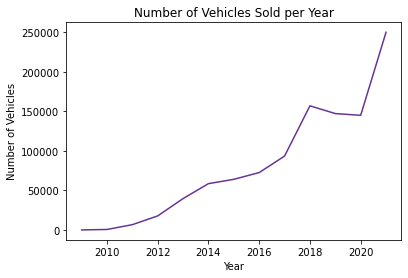

In [17]:
sns.lineplot(data = zev_sales.groupby('Year').sum(), x = 'Year', 
                    y = 'Number of Vehicles', color = 'rebeccapurple');
plt.title('Number of Vehicles Sold per Year');

zev_sales.groupby('Year').sum()['Number of Vehicles']

It looks like the sales of ZEVs in California has increased over time! It looks like there could potentially be a linear correlation between the number of years and the number of ZEVs sold. We now run a linear regression to see if this is the case. 

In [18]:
zev_sales['Year'] = zev_sales['Year'].astype(int) #- 2009
zev_sales['Number of Vehicles'] = zev_sales['Number of Vehicles'].astype(int)

print(sm.OLS(zev_sales['Number of Vehicles'], zev_sales['Year']).fit().summary())

# see that our coefficient is 0.0420, so that times some year would give us some amount of cars sold that year
# may not keep this however, since i cant find the intercept 
# also this is with the calendar years 2009, 2010, etc. we could also do it as number of years since 2009


                                 OLS Regression Results                                
Dep. Variable:     Number of Vehicles   R-squared (uncentered):                   0.035
Model:                            OLS   Adj. R-squared (uncentered):              0.035
Method:                 Least Squares   F-statistic:                              453.6
Date:                Thu, 01 Jun 2023   Prob (F-statistic):                    6.80e-99
Time:                        06:10:16   Log-Likelihood:                         -93555.
No. Observations:               12451   AIC:                                  1.871e+05
Df Residuals:                   12450   BIC:                                  1.871e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Which counties have the highest amount of ZEV sales?

Let's also make a bar graph of the number of sales for the top 10 counties. 


/tmp/ipykernel_8558/811805745.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.barplot(data = zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles',
/tmp/ipykernel_8558/811805745.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', ascending = False).head(10)


,Year,Number of Vehicles
County,,
Los Angeles,922034,281524
Orange,881710,132189
Santa Clara,805078,131768
San Diego,823264,82700
Alameda,786937,77064
San Mateo,772767,41111
Contra Costa,774811,40854
Riverside,750651,34723
San Francisco,750586,28370


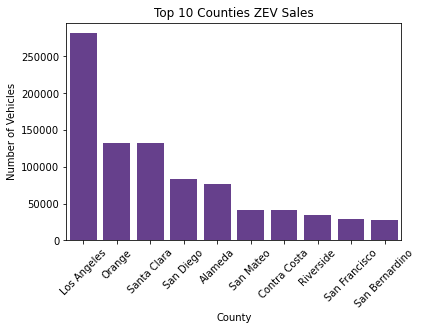

In [19]:
sns.barplot(data = zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', 
                ascending = False).head(10).reset_index(), x = 'County', y = 'Number of Vehicles', 
                   color = 'rebeccapurple')
plt.xticks(rotation=45)
plt.title('Top 10 Counties ZEV Sales')

zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', ascending = False).head(10)


This makes sense, intuitively. These counties are [the most populous](https://www.california-demographics.com/counties_by_population) as well. What is the cumulative number of sales per year? (i.e. if one car is sold year one, and two are sold year two, the cumulative number of sales by year two would be three.) 

We will also break it down by sales since X year, which will make it easier for us to compare with the amount of registrations some year.

In [20]:
by_year = zev_sales.groupby('Year').sum()

count_per_year = by_year['Number of Vehicles'].values

sum09 = []
sum10 = []
sum11 = []
sum12 = []
sum13 = []
sum14 = []
sum15 = []
sum16 = []
sum17 = []
sum18 = []
sum19 = []
sum20 = []
sum21 = []

for i in range(len(count_per_year)):
    sum09.append(sum(count_per_year[0:i + 1]))
    sum10.append(sum(count_per_year[1:i + 1]))
    sum11.append(sum(count_per_year[2:i + 1]))
    sum12.append(sum(count_per_year[3:i + 1]))
    sum13.append(sum(count_per_year[4:i + 1]))
    sum14.append(sum(count_per_year[5:i + 1]))
    sum15.append(sum(count_per_year[6:i + 1]))
    sum16.append(sum(count_per_year[7:i + 1]))
    sum17.append(sum(count_per_year[8:i + 1]))
    sum18.append(sum(count_per_year[9:i + 1]))
    sum19.append(sum(count_per_year[10:i + 1]))
    sum20.append(sum(count_per_year[11:i + 1]))
    sum21.append(sum(count_per_year[12:i + 1]))

    
    
by_year['Sales Since 2009'] = sum09
by_year['Sales Since 2010'] = sum10
by_year['Sales Since 2011'] = sum11
by_year['Sales Since 2012'] = sum12
by_year['Sales Since 2013'] = sum13
by_year['Sales Since 2014'] = sum14
by_year['Sales Since 2015'] = sum15
by_year['Sales Since 2016'] = sum16
by_year['Sales Since 2017'] = sum17
by_year['Sales Since 2018'] = sum18
by_year['Sales Since 2019'] = sum19
by_year['Sales Since 2020'] = sum20
by_year['Sales Since 2021'] = sum21




print('The total number of ZEVs sold between 2009 and 2021 is ' + str(sum(count_per_year)))

by_year

The total number of ZEVs sold between 2009 and 2021 is 1054067


/tmp/ipykernel_8558/3137241459.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_year = zev_sales.groupby('Year').sum()


,Number of Vehicles,Sales Since 2009,Sales Since 2010,Sales Since 2011,Sales Since 2012,Sales Since 2013,Sales Since 2014,Sales Since 2015,Sales Since 2016,Sales Since 2017,Sales Since 2018,Sales Since 2019,Sales Since 2020,Sales Since 2021
Year,,,,,,,,,,,,,,
2009,84,84,0,0,0,0,0,0,0,0,0,0,0,0
2010,661,745,661,0,0,0,0,0,0,0,0,0,0,0
2011,6743,7488,7404,6743,0,0,0,0,0,0,0,0,0,0
2012,17839,25327,25243,24582,17839,0,0,0,0,0,0,0,0,0
2013,39805,65132,65048,64387,57644,39805,0,0,0,0,0,0,0,0
2014,58663,123795,123711,123050,116307,98468,58663,0,0,0,0,0,0,0
2015,64134,187929,187845,187184,180441,162602,122797,64134,0,0,0,0,0,0
2016,72683,260612,260528,259867,253124,235285,195480,136817,72683,0,0,0,0,0
2017,93587,354199,354115,353454,346711,328872,289067,230404,166270,93587,0,0,0,0


We can also look at ZEV sales as a percentage of cars registered by county in 2021. We will perform the same data cleaning steps but only on the 2021 registration data. 

Now we prepare to merge datasets. This dataset will contain information about the number of automobiles and ZEVs sold between 2009 and 2021. Given the average age of a car is 12 years, we assume that a car sold in 2009 is still registered in 2021 (hence why we filtered the `zev_sales` dataset to between 2009 and 2021), so we will only be looking at registrations in 2021. 

In [21]:
by_county = zev_sales.groupby('County').sum().sort_values(by = 'County').reset_index()
by_county['County'] = by_county['County'].apply(str.lower)


merged = reg_2021.merge(by_county, left_on = 'Counties', right_on = 'County').drop(['County', 
                'Year_x', 'Year_y', 'Trucks', 'Total Vehicles'], axis = 1)

merged = merged.rename(columns = {'Counties': 'County', 'Number of Vehicles': 'Number of ZEVs'})

merged['Percentage ZEV'] = (merged['Number of ZEVs'] * 100) / merged['Autos']

merged.sort_values(by = 'Percentage ZEV', ascending = False).head(10)

/tmp/ipykernel_8558/3828425069.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_county = zev_sales.groupby('County').sum().sort_values(by = 'County').reset_index()


,County,Autos,Number of ZEVs,Percentage ZEV
43,santa clara,1332612.0,131768,9.887949
30,out of state,109678.0,9716,8.858659
20,marin,190777.0,16011,8.392521
0,alameda,1055138.0,77064,7.303689
38,san francisco,393078.0,28370,7.217397
41,san mateo,569797.0,41111,7.215026
29,orange,2271305.0,132189,5.819958
6,contra costa,824951.0,40854,4.952294
18,los angeles,6386830.0,281524,4.407883
44,santa cruz,176886.0,7621,4.308425


Again, we will plot the top ten counties with the highest ZEV sales by percentage in a bar plot.

/tmp/ipykernel_8558/4162628154.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.barplot(data = zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles',


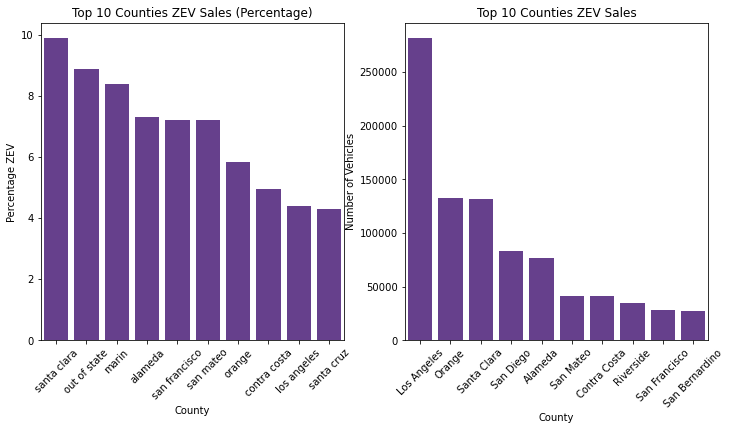

In [22]:
fig, axes = plt.subplots(figsize = (10,5))
fig.tight_layout()

plt.subplot(1, 2, 1)
sns.barplot(data = merged.sort_values(by = 'Percentage ZEV', ascending = False).head(10), x = 'County', 
            y = 'Percentage ZEV', color = 'rebeccapurple');
plt.xticks(rotation=45);
plt.title('Top 10 Counties ZEV Sales (Percentage)');

plt.subplot(1, 2, 2)
sns.barplot(data = zev_sales.groupby('County').sum().sort_values(by = 'Number of Vehicles', 
                ascending = False).head(10).reset_index(), x = 'County', y = 'Number of Vehicles', 
                   color = 'rebeccapurple');
plt.xticks(rotation=45);
plt.title('Top 10 Counties ZEV Sales');


We see that the the counties with the highest ZEV sales do not necessarily correspond with the highest percentage of ZEV sales.

## Vehicle Registrations

We are next going to look at how both the total number of vehicle registrations as well as the amount of electric vehicle registrations as a proportion of the total number of registrations has increased over time, both at the state and national level.

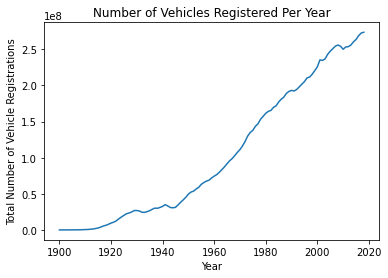

                                 OLS Regression Results                                
Dep. Variable:                  Total   R-squared (uncentered):                   0.577
Model:                            OLS   Adj. R-squared (uncentered):              0.573
Method:                 Least Squares   F-statistic:                              160.9
Date:                Thu, 01 Jun 2023   Prob (F-statistic):                    8.76e-24
Time:                        06:10:16   Log-Likelihood:                         -2348.1
No. Observations:                 119   AIC:                                      4698.
Df Residuals:                     118   BIC:                                      4701.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
# Plot and take linear regression statistics from total vehicles registered
fig1 = sns.lineplot(data=motor_total, x='year', y = 'Total')
plt.xlabel('Year')
plt.ylabel('Total Number of Vehicle Registrations')
plt.title('Number of Vehicles Registered Per Year')
plt.show()
print(sm.OLS(motor_total['Total'], motor_total['Year']).fit().summary())

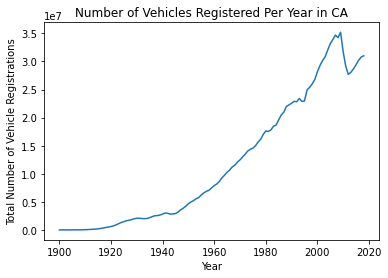

                                 OLS Regression Results                                
Dep. Variable:              Total_Cal   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.533
Method:                 Least Squares   F-statistic:                              136.8
Date:                Thu, 01 Jun 2023   Prob (F-statistic):                    1.89e-21
Time:                        06:10:17   Log-Likelihood:                         -2099.4
No. Observations:                 119   AIC:                                      4201.
Df Residuals:                     118   BIC:                                      4204.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
# Plot and take linear regression statistics from total vehicles registered in California
fig2 = sns.lineplot(data=motor_cal, x='Year', y = 'Total_Cal')
plt.xlabel('Year')
plt.ylabel('Total Number of Vehicle Registrations')
plt.title('Number of Vehicles Registered Per Year in CA')
plt.show()
print(sm.OLS(motor_cal['Total_Cal'], motor_cal['Year']).fit().summary())

We're now going to look specifically at the percentages of vehicles registered over the past few years that are electric. We can see that both in California and in the United States, the percentage rate of increase over the past few years, while minimal, is still growing exponentially.

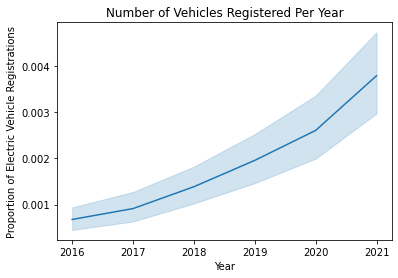

                                 OLS Regression Results                                
Dep. Variable:             Percentage   R-squared (uncentered):                   0.400
Model:                            OLS   Adj. R-squared (uncentered):              0.399
Method:                 Least Squares   F-statistic:                              207.7
Date:                Thu, 01 Jun 2023   Prob (F-statistic):                    2.01e-36
Time:                        06:10:17   Log-Likelihood:                          1451.4
No. Observations:                 312   AIC:                                     -2901.
Df Residuals:                     311   BIC:                                     -2897.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

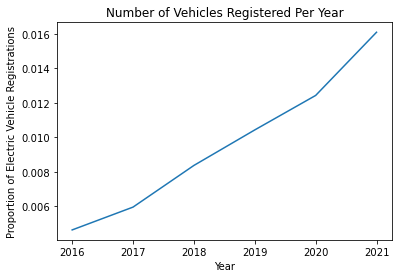

                                 OLS Regression Results                                
Dep. Variable:             Percentage   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              31.05
Date:                Thu, 01 Jun 2023   Prob (F-statistic):                     0.00256
Time:                        06:10:17   Log-Likelihood:                          24.808
No. Observations:                   6   AIC:                                     -47.62
Df Residuals:                       5   BIC:                                     -47.82
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/conda/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [25]:
# Plot and take linear regression statistics from pecentage of EV's
fig3 = sns.lineplot(data=registration, x='Year', y = 'Percentage')
plt.xlabel('Year')
plt.ylabel('Proportion of Electric Vehicle Registrations')
plt.title('Number of Vehicles Registered Per Year')
plt.show()
print(sm.OLS(registration['Percentage'], registration['Year']).fit().summary())

# Plot and take linear regression statistics from pecentage of EV's in California
fig4 = sns.lineplot(data=cal_registration, x='Year', y = 'Percentage')
plt.xlabel('Year')
plt.ylabel('Proportion of Electric Vehicle Registrations')
plt.title('Number of Vehicles Registered Per Year')
plt.show()
print(sm.OLS(cal_registration['Percentage'], cal_registration['Year']).fit().summary())

From this, we can see that California is rapidly increasing the number of electric vehicle registrations. This bodes well towards our overall hypothesis.

## Car Ownership vs EV Sales

We can first take a look at car ownership/registration over time and how it compares to the total amount of Zev sales since 2009.

Text(0.5, 1.0, 'Total Trend in Registrations')

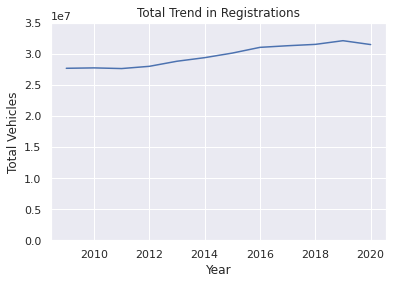

In [26]:
sns.set(font_scale=1)

plt.ylim([0, 35000000])
sns.lineplot(data = regs_tot, x = 'Year', y='Total Vehicles').set_title("Total Trend in Registrations")


Text(0.5, 1.0, 'Trend in Registrations for Non-Electric Vehicles')

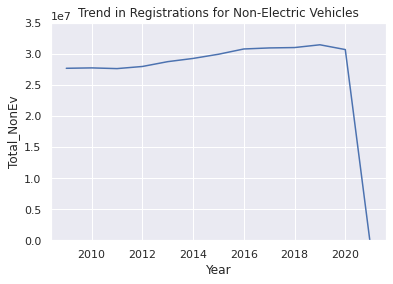

In [27]:
plt.ylim([0, 35000000])
sns.lineplot(data = regs_v_ev, x = 'Year', y="Total_NonEv").set_title("Trend in Registrations for Non-Electric Vehicles")


<AxesSubplot:xlabel='Year', ylabel='Sales Since 2009'>

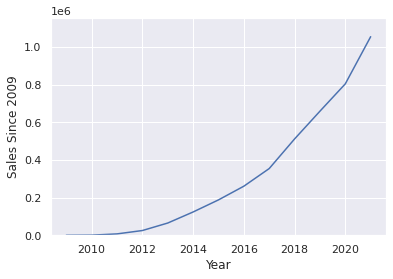

In [28]:
plt.ylim([0,max(by_year['Sales Since 2009'])+100000])
sns.lineplot(data = by_year, x = 'Year', y='Sales Since 2009')

,Year,Autos,Trucks,Total_Vehicles,Delta,EV_Sales,Sales Since 2009,Sales Since 2010,Sales Since 2011,Sales Since 2012,Sales Since 2013,Sales Since 2014,Sales Since 2015,Sales Since 2016,Sales Since 2017,Sales Since 2018,Sales Since 2019,Sales Since 2020,Sales Since 2021,Total_NonEv
0,2009,21898286.0,5788504.0,27686790.0,-152695.0,84.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27686706.0
1,2010,22040779.0,5711052.0,27751831.0,65041.0,661.0,745.0,661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27751086.0
2,2011,22083049.0,5561453.0,27644502.0,-107329.0,6743.0,7488.0,7404.0,6743.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27637014.0
3,2012,22473717.0,5530290.0,28004007.0,359505.0,17839.0,25327.0,25243.0,24582.0,17839.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27978680.0
4,2013,23237523.0,5584074.0,28821597.0,817590.0,39805.0,65132.0,65048.0,64387.0,57644.0,39805.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28756465.0
5,2014,23805920.0,5591533.0,29397453.0,575856.0,58663.0,123795.0,123711.0,123050.0,116307.0,98468.0,58663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29273658.0
6,2015,24487807.0,5648187.0,30135994.0,738541.0,64134.0,187929.0,187845.0,187184.0,180441.0,162602.0,122797.0,64134.0,0.0,0.0,0.0,0.0,0.0,0.0,29948065.0
7,2016,25244537.0,5812320.0,31056857.0,920863.0,72683.0,260612.0,260528.0,259867.0,253124.0,235285.0,195480.0,136817.0,72683.0,0.0,0.0,0.0,0.0,0.0,30796245.0
8,2017,25467663.0,5850286.0,31317949.0,261092.0,93587.0,354199.0,354115.0,353454.0,346711.0,328872.0,289067.0,230404.0,166270.0,93587.0,0.0,0.0,0.0,0.0,30963750.0
9,2018,25646228.0,5890475.0,31536703.0,218754.0,157143.0,511342.0,511258.0,510597.0,503854.0,486015.0,446210.0,387547.0,323413.0,250730.0,157143.0,0.0,0.0,0.0,31025361.0


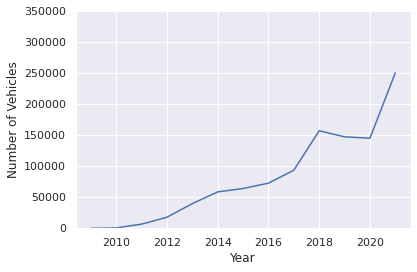

In [29]:
plt.ylim([0,max(by_year['Number of Vehicles'])+100000])
sns.lineplot(data = by_year, x = 'Year', y='Number of Vehicles')
regs_v_ev

While total car ownership has fluctuated very little over the last 10 years, the sale of ZEV vehicles has increased significantly. However, as this is just a small part of overall car sales as seen, is this trend simply due to the minor uptick in car registrations since 2010 or is this statistically significant?

In [30]:

outcome, predictors = patsy.dmatrices('EV_Sales ~ Year + Total_NonEv', regs_v_ev)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               EV_Sales   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     126.7
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           7.89e-08
Time:                        06:10:18   Log-Likelihood:                -142.66
No. Observations:                  13   AIC:                             291.3
Df Residuals:                      10   BIC:                             293.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -3.32e+07   2.54e+06    -13.077      

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


There does seem to be some significant correlation outside to year and ev car sales even when considering other car sales.

We can also note that for the linear model the Adj. R-squared is 0.89, however, the data looks more quadradic in the graphs, so we will see if a quadradic line of regression is more appropriate.

In [31]:
mymodel = np.poly1d(np.polyfit(regs_v_ev['EV_Sales'], regs_v_ev['Year'], 2))

print(r2_score(regs_v_ev['Year'], mymodel(regs_v_ev['EV_Sales']))) 

0.9714913203034206


There does seem to be a stronger correlation to the quadradic model, so for further analysis, a quadratic line of regression will be used.

## EV Sales in the United States

In [32]:
# this finds sales per month
ev_dif = ev_numbers
ev_dif.insert(loc = 0, column = 'A', value = np.zeros(57))
ev_dif = ev_dif.diff(axis = 1)
ev_dif = ev_dif.drop(columns = 'A')
ev_numbers = ev_numbers.drop(columns = 'A')

# this sums the columns to get total sales across all models per month
ev_sum = ev_numbers.sum(axis = 0)
ev_sum_dif = ev_dif.sum(axis = 0)

Text(0.5, 1.0, 'Total Sales of EV Vehicles in the United States')

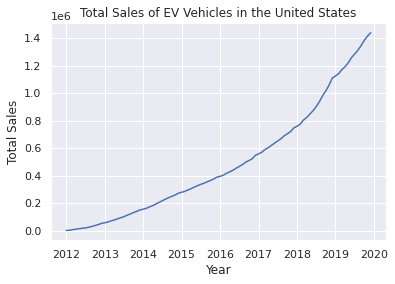

In [33]:
total_graph = ev_sum.plot.line()
total_graph.set_xlabel('Year')
total_graph.set_ylabel('Total Sales')
total_graph.set_title('Total Sales of EV Vehicles in the United States')

This plot shows the total sales of EV vehicles from 2012-2019 in the US. Total means all cars sold added through time so every year adds on top of one another as time goes on. There will always be an upward trend in this graph as it is the total sold, but note that the total increases faster as time goes on.

Text(0.5, 1.0, 'Sales Per Month of EV Vehicles in the United States')

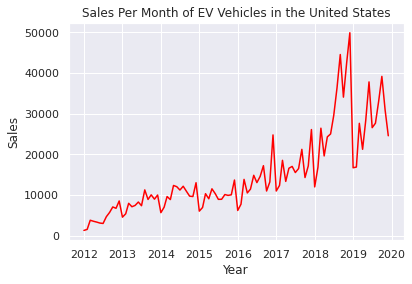

In [34]:
sales_graph = ev_sum_dif.plot.line(color = 'red')
sales_graph.set_xlabel('Year')
sales_graph.set_ylabel('Sales')
sales_graph.set_title('Sales Per Month of EV Vehicles in the United States')

This plot shows the sales per month of EV vehicles from 2012-2019 in the US. As we can see there is an obvious upwards trend in EV sales over these years.